In [9]:
import re
import random
import numpy as np
import pandas as pd
from collections import Counter, defaultdict
from typing import Dict, List, Tuple, Optional
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
    DataCollatorWithPadding
)
import matplotlib.pyplot as plt
import seaborn as sns
import arabic_reshaper
from bidi.algorithm import get_display
import warnings
warnings.filterwarnings('ignore')


In [ ]:
class Config:
    MODEL_NAME = "CAMeL-Lab/bert-base-arabic-camelbert-ca-poetry"
    MAX_LENGTH = 512
    SEGMENT_LENGTH = 256  
    SEGMENT_STRIDE = 128  
    BATCH_SIZE = 16
    LEARNING_RATE = 3e-5
    NUM_EPOCHS = 10
    WARMUP_RATIO = 0.1
    WEIGHT_DECAY = 0.01
    SEED = 42
    CSV_PATH = "/Arabic_Poetry_Dataset.csv"
    OUTPUT_DIR = "/arabic_poetry_weighted_model"

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(Config.SEED)

In [ ]:
def reshape_arabic(text):
    """Reshape Arabic text for proper display"""
    if pd.isna(text):
        return ""
    reshaped = arabic_reshaper.reshape(str(text))
    return get_display(reshaped)

def normalize_arabic_text(text: str) -> str:
    """Normalize Arabic text"""
    if pd.isna(text):
        return ""
    text = re.sub(r'[\u064B-\u0652\u0617-\u061A\u0657-\u0658]', '', text)
    text = re.sub(r'[إأآٱ]', 'ا', text)
    text = re.sub(r'ى', 'ي', text)
    text = re.sub(r'ة', 'ه', text)
    text = re.sub(r'ـ', '', text)
    text = re.sub(r'[^\u0600-\u06FF\u0750-\u077F\u08A0-\u08FF\s\.\!\?\,\n]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

def extract_all_tags_from_dataset(df: pd.DataFrame) -> Dict[str, set]:
    """Extract all unique tags from the dataset and categorize them"""
    all_tags = []
    for tags in df['poem_tags'].dropna():
        parts = re.split('[,،]', tags)
        all_tags.extend([t.strip() for t in parts if t.strip()])

    categories = {
        'meter': set(),
        'rhyme': set(),
        'form': set(),
        'theme': set()
    }

    form_keywords = {
        "عمودي", "عموديه", "عمودية",
        "موشح", "زجل",
        "التفعيلة", "التفعيله", "تفعيلة", "تفعيله",
        "نثرية", "نثريه", "نثري",
        "قصيدة قصيرة", "قصيده قصيره", "قصائد قصيرة", "قصائد قصيره",
        "قصيدة طويلة", "قصيده طويله", "قصائد طويلة", "قصائد طويله",
        "مقطوع", "مقطوعة", "مقطوعه",
        "رباعية", "رباعيه", "رباعيات",
        "خماسية", "خماسيه", "مخمس",
        "سداسية", "سداسيه", "مسدس",
        "سباعية", "سباعيه",
        "ثمانية", "ثمانيه", "مثمن",
        "عشارية", "عشاريه", "معشر",
        "دوبيت", "قطعة", "قطعه", "نتفة", "نتفه",
        "أرجوزة", "ارجوزه", "أرجوزه",
        "ملحمة", "ملحمه"
    }

    normalized_form_keywords = set()
    for keyword in form_keywords:
        normalized_form_keywords.add(keyword)
        normalized = keyword.replace('ة', 'ه').replace('ى', 'ي')
        normalized_form_keywords.add(normalized)

    for tag in set(all_tags):
        normalized_tag = tag.replace('ة', 'ه').replace('ى', 'ي')

        if 'بحر' in tag:  
            categories['meter'].add(tag)
        elif 'قافية' in tag or 'قافيه' in tag:  
            categories['rhyme'].add(tag)
        elif normalized_tag in normalized_form_keywords or tag in form_keywords: 
            categories['form'].add(tag)
        else: 
            categories['theme'].add(tag)

    return categories

def normalize_tag_spelling(tag: str) -> str:
    """Normalize tag spelling to canonical form"""
    normalized = tag.replace('ة', 'ه').replace('ى', 'ي')

    canonical_forms = {
        'عموديه': 'عمودية',
        'قصيده قصيره': 'قصيدة قصيرة',
        'قصائد قصيره': 'قصائد قصيرة',
        'قصيده طويله': 'قصيدة طويلة',
        'قصائد طويله': 'قصائد طويلة',
        'التفعيله': 'التفعيلة',
        'تفعيله': 'تفعيلة',
        'نثريه': 'نثرية',
        'مقطوعه': 'مقطوعة',
        'رباعيه': 'رباعية',
        'خماسيه': 'خماسية',
        'سداسيه': 'سداسية',
        'سباعيه': 'سباعية',
        'ثمانيه': 'ثمانية',
        'عشاريه': 'عشارية',
        'قطعه': 'قطعة',
        'نتفه': 'نتفة',
        'ارجوزه': 'أرجوزة',
        'أرجوزه': 'أرجوزة',
        'ملحمه': 'ملحمة',
        'قافيه': 'قافية'
    }

    return canonical_forms.get(normalized, tag)

def extract_metadata_features(tags: str, tag_categories: Dict[str, set]) -> Dict[str, List[str]]:
    """Extract structured features from poem tags using discovered categories"""
    if pd.isna(tags) or not tags:
        return {'meter': [], 'theme': [], 'form': [], 'rhyme': []}

    features = {
        'meter': [],
        'theme': [],
        'form': [],
        'rhyme': []
    }

    parts = re.split('[,،]', tags)
    tag_list = [t.strip() for t in parts if t.strip()]

    form_keywords = {
        "عمودي", "عموديه", "عمودية",
        "موشح", "زجل",
        "التفعيلة", "التفعيله", "تفعيلة", "تفعيله",
        "نثرية", "نثريه", "نثري",
        "قصيدة قصيرة", "قصيده قصيره", "قصائد قصيرة", "قصائد قصيره",
        "قصيدة طويلة", "قصيده طويله", "قصائد طويلة", "قصائد طويله",
        "مقطوع", "مقطوعة", "مقطوعه",
        "رباعية", "رباعيه", "رباعيات",
        "خماسية", "خماسيه", "مخمس",
        "سداسية", "سداسيه", "مسدس",
        "دوبيت", "قطعة", "قطعه", "نتفة", "نتفه",
        "أرجوزة", "ارجوزه", "أرجوزه"
    }

    for tag in tag_list:
        normalized_tag = tag.replace('ة', 'ه').replace('ى', 'ي')

        canonical_tag = normalize_tag_spelling(tag)

        if tag in tag_categories['meter']:
            features['meter'].append(canonical_tag)
        elif tag in tag_categories['rhyme']:
            features['rhyme'].append(canonical_tag)
        elif tag in tag_categories['form']:
            features['form'].append(canonical_tag)
        else:
            if normalized_tag in [k.replace('ة', 'ه').replace('ى', 'ي') for k in form_keywords] or tag in form_keywords:
                features['form'].append(canonical_tag)
            else:
                features['theme'].append(canonical_tag)

    for key in features:
        features[key] = list(dict.fromkeys(features[key]))

    return features

In [ ]:
def remove_non_discriminative_features(metadata_features):
    """Remove non-discriminative features like 'عمودي' that appear in almost all poems"""
    if 'form' in metadata_features:
        metadata_features['form'] = [
            form for form in metadata_features['form']
            if form not in ['عمودي', 'عموديه', 'عمودية']
        ]
    return metadata_features

In [13]:
print("Loading and preprocessing data...")
df = pd.read_csv(Config.CSV_PATH, encoding='utf-8')

Loading and preprocessing data...


In [ ]:
df = df.dropna(subset=['poem_text', 'poet_era']).reset_index(drop=True)
print(f"Dataset after removing missing values: {len(df)} poems")

df = df.drop_duplicates(subset=['poem_text'], keep='first').reset_index(drop=True)
print(f"Dataset after removing duplicates: {len(df)} poems")

Dataset after removing missing values: 74010 poems
Dataset after removing duplicates: 73640 poems


In [ ]:
df['normalized_text'] = df['poem_text'].apply(normalize_arabic_text)
tag_categories = extract_all_tags_from_dataset(df)

df['metadata_features'] = df['poem_tags'].apply(
    lambda tags: extract_metadata_features(tags, tag_categories)
)

In [ ]:
df['metadata_features'] = df['metadata_features'].apply(remove_non_discriminative_features)

df['num_lines'] = df['poem_text'].str.count('\n') + 1
df['num_words'] = df['normalized_text'].str.split().str.len()

In [ ]:
def handle_long_poems(df, max_lines=100):
    """Handle long poems through segmentation or truncation"""
    print(f"\nHandling long poems (>{max_lines} lines)...")

    long_poem_mask = df['num_lines'] > max_lines
    long_poems = df[long_poem_mask]
    print(f"Found {len(long_poems)} long poems")

    long_poems_by_era = long_poems['poet_era'].value_counts()
    era_counts = df['poet_era'].value_counts()

    minority_threshold = era_counts.quantile(0.3)
    minority_eras = era_counts[era_counts <= minority_threshold].index.tolist()

    print(f"Minority eras (will segment): {minority_eras}")

    processed_rows = []

    for idx, row in df.iterrows():
        if row['num_lines'] <= max_lines:
            processed_rows.append(row)
        else:
            if row['poet_era'] in minority_eras:
                segments = segment_poem(row['normalized_text'], Config.SEGMENT_LENGTH, Config.SEGMENT_STRIDE)
                for i, segment in enumerate(segments[:3]): 
                    new_row = row.copy()
                    new_row['normalized_text'] = segment
                    new_row['is_segment'] = True
                    new_row['segment_id'] = i
                    new_row['original_length'] = row['num_lines']
                    processed_rows.append(new_row)
            else:
                lines = row['normalized_text'].split('\n')
                truncated_text = '\n'.join(lines[:max_lines])
                row['normalized_text'] = truncated_text
                row['is_truncated'] = True
                row['original_length'] = row['num_lines']
                processed_rows.append(row)

    processed_df = pd.DataFrame(processed_rows).reset_index(drop=True)
    print(f"Dataset after handling long poems: {len(processed_df)} samples")

    return processed_df

def segment_poem(text, max_length, stride):
    """Segment a long poem into overlapping chunks"""
    words = text.split()
    segments = []

    for i in range(0, len(words), max_length - stride):
        segment = ' '.join(words[i:i + max_length])
        if len(segment.split()) > 50:  
            segments.append(segment)

    return segments

In [ ]:
df = handle_long_poems(df)


Handling long poems (>100 lines)...
Found 3233 long poems
Minority eras (will segment): ['المخضرمون', 'العصر الجاهلي', 'العصر الاسلامي']
Dataset after handling long poems: 73796 samples


In [ ]:
def create_stratified_splits(df, test_size=0.15, val_size=0.15):
    """Create train/val/test splits with stratification by poet"""
    poet_to_era = df.groupby('poet_name')['poet_era'].first().to_dict()

    era_poets = defaultdict(list)
    for poet, era in poet_to_era.items():
        era_poets[era].append(poet)

    train_poets, val_poets, test_poets = [], [], []

    for era, poets in era_poets.items():
        np.random.shuffle(poets)
        n_poets = len(poets)
        n_test = max(1, int(n_poets * test_size))
        n_val = max(1, int(n_poets * val_size))

        test_poets.extend(poets[:n_test])
        val_poets.extend(poets[n_test:n_test + n_val])
        train_poets.extend(poets[n_test + n_val:])

    train_df = df[df['poet_name'].isin(train_poets)].reset_index(drop=True)
    val_df = df[df['poet_name'].isin(val_poets)].reset_index(drop=True)
    test_df = df[df['poet_name'].isin(test_poets)].reset_index(drop=True)

    return train_df, val_df, test_df


In [ ]:
train_df, val_df, test_df = create_stratified_splits(df)

print(f"\nData splits:")
print(f"Train: {len(train_df)} samples")
print(f"Validation: {len(val_df)} samples")
print(f"Test: {len(test_df)} samples")

print("\nClass distribution in training set:")
train_class_dist = train_df['poet_era'].value_counts().sort_index()
for era, count in train_class_dist.items():
    print(f"  {era}: {count} ({count/len(train_df)*100:.1f}%)")

class_weights = compute_class_weight(
    'balanced',
    classes=np.array(sorted(train_df['poet_era'].unique())),
    y=train_df['poet_era'].values
)

label_encoder = LabelEncoder()
label_encoder.fit(sorted(df['poet_era'].unique()))
num_classes = len(label_encoder.classes_)

print(f"\nNumber of classes: {num_classes}")
print(f"Class weights: {class_weights}")


Data splits:
Train: 54133 samples
Validation: 12453 samples
Test: 7210 samples

Class distribution in training set:
  العصر الأندلسي: 3653 (6.7%)
  العصر الاسلامي: 135 (0.2%)
  العصر الاموي: 4806 (8.9%)
  العصر الايوبي: 5067 (9.4%)
  العصر الجاهلي: 1537 (2.8%)
  العصر العباسي: 20731 (38.3%)
  العصر العثماني: 5171 (9.6%)
  العصر المملوكي: 10766 (19.9%)
  المخضرمون: 2267 (4.2%)

Number of classes: 9
Class weights: [ 1.64653101 44.55390947  1.25151431  1.1870491   3.91332321  0.29013447
  1.16317497  0.55868268  2.65318826]


In [ ]:
class ArabicPoetryDataset(Dataset):
    def __init__(self, dataframe, tokenizer, label_encoder, max_length=512):
        self.df = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.label_encoder = label_encoder
        self.max_length = max_length

        self.labels = self.label_encoder.transform(self.df['poet_era'].values)

    def __len__(self):
        return len(self.df)

    def create_input_text(self, row):
        """Create structured input with metadata"""
        text = row['normalized_text']
        features = row['metadata_features']

        parts = []

        if features.get('form'):
            parts.append(f"[النوع] {' '.join(features['form'][:2])}")
        if features.get('meter'):
            parts.append(f"[البحر] {' '.join(features['meter'][:1])}")
        if features.get('theme'):
            parts.append(f"[الموضوع] {' '.join(features['theme'][:2])}")

        num_lines = text.count('\n') + 1
        if num_lines < 5:
            parts.append("[قصيرة]")
        elif num_lines < 20:
            parts.append("[متوسطة]")
        else:
            parts.append("[طويلة]")

        parts.append(text)

        return " ".join(parts)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text = self.create_input_text(row)

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }


In [ ]:
print("\nInitializing tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(Config.MODEL_NAME)

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token


special_tokens = ['[النوع]', '[البحر]', '[الموضوع]', '[قصيرة]', '[متوسطة]', '[طويلة]']
tokenizer.add_special_tokens({'additional_special_tokens': special_tokens})

train_dataset = ArabicPoetryDataset(train_df, tokenizer, label_encoder, Config.MAX_LENGTH)
val_dataset = ArabicPoetryDataset(val_df, tokenizer, label_encoder, Config.MAX_LENGTH)
test_dataset = ArabicPoetryDataset(test_df, tokenizer, label_encoder, Config.MAX_LENGTH)

print("\nInitializing model...")
model = AutoModelForSequenceClassification.from_pretrained(
    Config.MODEL_NAME,
    num_labels=num_classes,
    problem_type="single_label_classification",
    ignore_mismatched_sizes=True
)
model.resize_token_embeddings(len(tokenizer))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(f"Model loaded on {device}")



Initializing tokenizer...


tokenizer_config.json:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/3.05k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/305k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]


Initializing model...


pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-ca-poetry and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([23, 768]) in the checkpoint and torch.Size([9, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([23]) in the checkpoint and torch.Size([9]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Model loaded on cuda


In [21]:
class WeightedTrainer(Trainer):
    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        if class_weights is not None:
            self.class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
        else:
            self.class_weights = None

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get('logits')

        if self.class_weights is not None:
            loss_fct = nn.CrossEntropyLoss(weight=self.class_weights)
        else:
            loss_fct = nn.CrossEntropyLoss()

        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss


In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(labels, predictions)
    macro_f1 = f1_score(labels, predictions, average='macro')
    weighted_f1 = f1_score(labels, predictions, average='weighted')

    per_class_f1 = f1_score(labels, predictions, average=None)

    return {
        'accuracy': accuracy,
        'macro_f1': macro_f1,
        'weighted_f1': weighted_f1,
        'min_f1': per_class_f1.min(),
        'max_f1': per_class_f1.max()
    }


In [ ]:
training_args = TrainingArguments(
    output_dir=Config.OUTPUT_DIR,
    num_train_epochs=Config.NUM_EPOCHS,
    per_device_train_batch_size=Config.BATCH_SIZE,
    per_device_eval_batch_size=Config.BATCH_SIZE * 2,
    warmup_ratio=Config.WARMUP_RATIO,
    weight_decay=Config.WEIGHT_DECAY,
    learning_rate=Config.LEARNING_RATE,

    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=100,

    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,

    fp16=torch.cuda.is_available(),
    dataloader_drop_last=False,
    seed=Config.SEED,
    report_to="none",
)

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2, early_stopping_threshold=0.01)],
    class_weights=class_weights
)


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [24]:
print("\nStarting training with class weights...")
train_result = trainer.train()

print("\nTraining completed!")
print(f"Training loss: {train_result.training_loss:.4f}")


Starting training with class weights...


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1,Min F1,Max F1
1,1.583200,1.798232,0.257769,0.220978,0.231947,0.000000,0.453752
2,1.415700,1.776411,0.318076,0.298614,0.299245,0.000000,0.698198
3,1.188100,1.809021,0.357344,0.327549,0.359358,0.000000,0.753623
4,0.866400,2.247587,0.326668,0.309443,0.334785,0.000000,0.600349



Training completed!
Training loss: 1.3299


In [ ]:
def comprehensive_evaluation(model, dataset, dataset_name, label_encoder):
    """Perform comprehensive evaluation with visualizations"""
    print(f"\n{'='*60}")
    print(f"EVALUATING ON {dataset_name.upper()} SET")
    print(f"{'='*60}")

    predictions = trainer.predict(dataset)
    y_true = predictions.label_ids
    y_pred = np.argmax(predictions.predictions, axis=1)

    accuracy = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    weighted_f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"\nOverall Metrics:")
    print(f"  Accuracy: {accuracy:.3f}")
    print(f"  Macro F1: {macro_f1:.3f}")
    print(f"  Weighted F1: {weighted_f1:.3f}")

    print(f"\nDetailed Classification Report:")
    class_names = [reshape_arabic(era) for era in label_encoder.classes_]
    report = classification_report(y_true, y_pred, target_names=label_encoder.classes_, digits=3)
    print(report)

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {dataset_name} Set', fontsize=16, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    print(f"\nMost Confused Era Pairs (>10% confusion rate):")
    confused_pairs = []
    for i in range(len(label_encoder.classes_)):
        for j in range(len(label_encoder.classes_)):
            if i != j and cm_normalized[i, j] > 0.1:
                confused_pairs.append((
                    label_encoder.classes_[i],
                    label_encoder.classes_[j],
                    cm_normalized[i, j],
                    cm[i, j]
                ))

    confused_pairs.sort(key=lambda x: x[2], reverse=True)
    for era1, era2, rate, count in confused_pairs[:10]:
        print(f"  {era1} → {era2}: {rate:.1%} ({count} samples)")

    return {
        'accuracy': accuracy,
        'macro_f1': macro_f1,
        'weighted_f1': weighted_f1,
        'predictions': y_pred,
        'confusion_matrix': cm
    }



EVALUATING ON VALIDATION SET



Overall Metrics:
  Accuracy: 0.318
  Macro F1: 0.299
  Weighted F1: 0.299

Detailed Classification Report:
                precision    recall  f1-score   support

العصر الأندلسي      0.159     0.301     0.208      1212
العصر الاسلامي      0.000     0.000     0.000        32
  العصر الاموي      0.463     0.404     0.432      1649
 العصر الايوبي      0.505     0.035     0.065      2767
 العصر الجاهلي      0.787     0.628     0.698       247
 العصر العباسي      0.448     0.468     0.458      3033
العصر العثماني      0.269     0.429     0.331      1417
العصر المملوكي      0.259     0.315     0.284      1508
     المخضرمون      0.164     0.298     0.212       588

      accuracy                          0.318     12453
     macro avg      0.339     0.320     0.299     12453
  weighted avg      0.383     0.318     0.299     12453



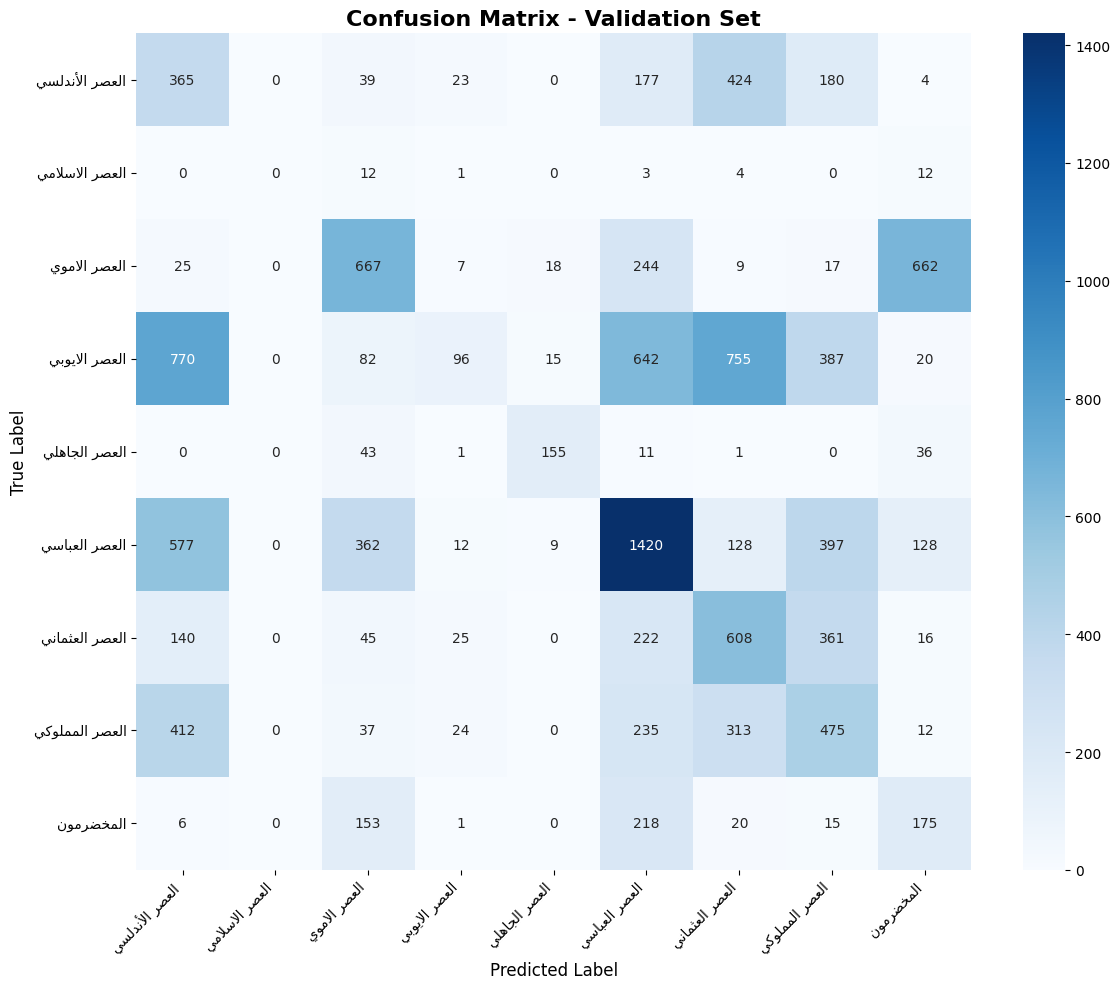


Most Confused Era Pairs (>10% confusion rate):
  العصر الاموي → المخضرمون: 40.1% (662 samples)
  العصر الاسلامي → العصر الاموي: 37.5% (12 samples)
  العصر الاسلامي → المخضرمون: 37.5% (12 samples)
  المخضرمون → العصر العباسي: 37.1% (218 samples)
  العصر الأندلسي → العصر العثماني: 35.0% (424 samples)
  العصر الايوبي → العصر الأندلسي: 27.8% (770 samples)
  العصر المملوكي → العصر الأندلسي: 27.3% (412 samples)
  العصر الايوبي → العصر العثماني: 27.3% (755 samples)
  المخضرمون → العصر الاموي: 26.0% (153 samples)
  العصر العثماني → العصر المملوكي: 25.5% (361 samples)

EVALUATING ON TEST SET



Overall Metrics:
  Accuracy: 0.393
  Macro F1: 0.310
  Weighted F1: 0.388

Detailed Classification Report:
                precision    recall  f1-score   support

العصر الأندلسي      0.293     0.443     0.353      1209
العصر الاسلامي      0.000     0.000     0.000       108
  العصر الاموي      0.330     0.643     0.436       560
 العصر الايوبي      0.113     0.055     0.074       254
 العصر الجاهلي      0.855     0.164     0.275       573
 العصر العباسي      0.571     0.407     0.475      2459
العصر العثماني      0.493     0.371     0.424       897
العصر المملوكي      0.273     0.323     0.296       783
     المخضرمون      0.345     0.662     0.453       367

      accuracy                          0.393      7210
     macro avg      0.364     0.341     0.310      7210
  weighted avg      0.450     0.393     0.388      7210



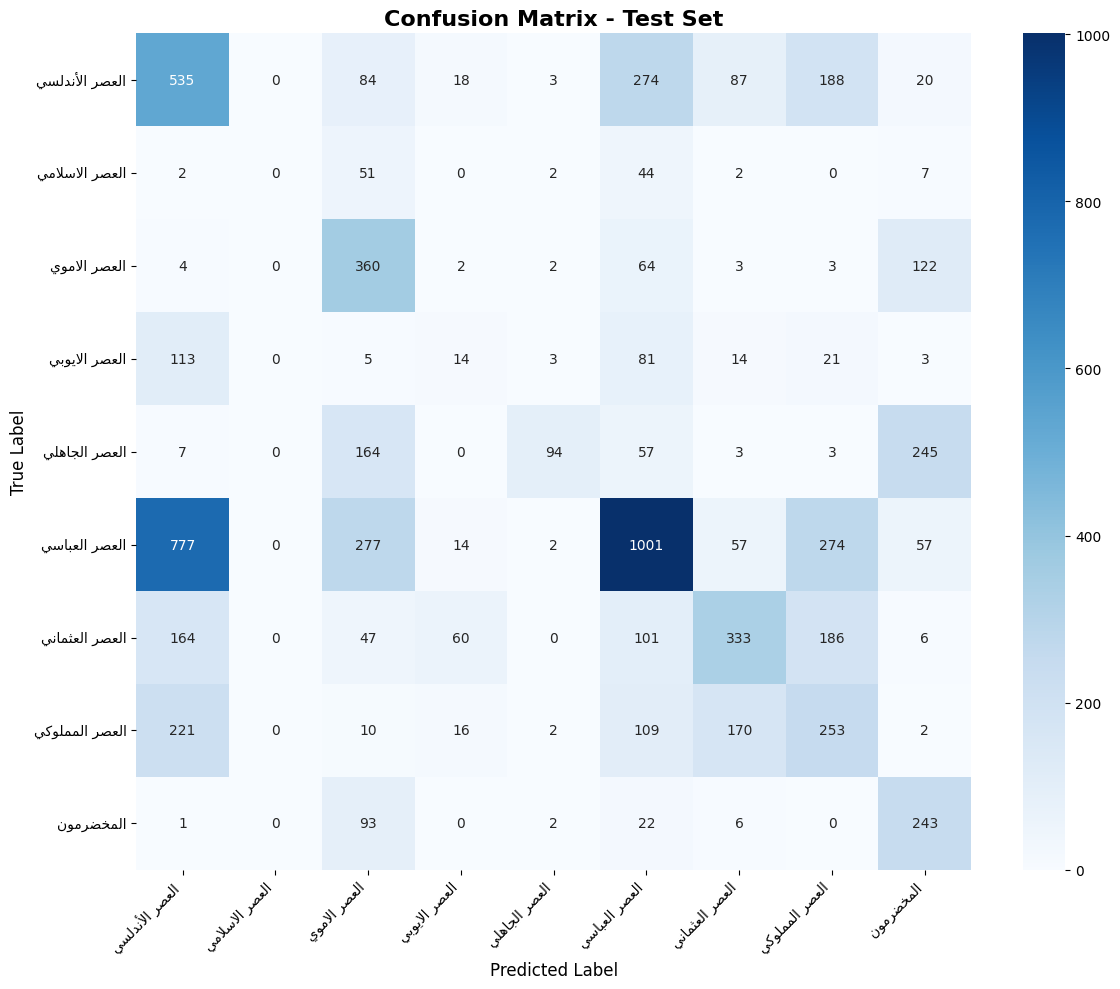


Most Confused Era Pairs (>10% confusion rate):
  العصر الاسلامي → العصر الاموي: 47.2% (51 samples)
  العصر الايوبي → العصر الأندلسي: 44.5% (113 samples)
  العصر الجاهلي → المخضرمون: 42.8% (245 samples)
  العصر الاسلامي → العصر العباسي: 40.7% (44 samples)
  العصر الايوبي → العصر العباسي: 31.9% (81 samples)
  العصر العباسي → العصر الأندلسي: 31.6% (777 samples)
  العصر الجاهلي → العصر الاموي: 28.6% (164 samples)
  العصر المملوكي → العصر الأندلسي: 28.2% (221 samples)
  المخضرمون → العصر الاموي: 25.3% (93 samples)
  العصر الأندلسي → العصر العباسي: 22.7% (274 samples)


In [26]:
val_results = comprehensive_evaluation(model, val_dataset, "Validation", label_encoder)
test_results = comprehensive_evaluation(model, test_dataset, "Test", label_encoder)


In [ ]:
def error_analysis(model, dataset, label_encoder, n_examples=10):
    """Detailed error analysis"""
    print(f"\n{'='*60}")
    print("ERROR ANALYSIS")
    print(f"{'='*60}")

    predictions = trainer.predict(dataset)
    y_true = predictions.label_ids
    y_pred = np.argmax(predictions.predictions, axis=1)
    probs = torch.softmax(torch.tensor(predictions.predictions), dim=-1).numpy()

    errors = y_true != y_pred
    error_indices = np.where(errors)[0]

    if len(error_indices) == 0:
        print("No errors found!")
        return

    print(f"\nTotal errors: {len(error_indices)} / {len(y_true)} ({len(error_indices)/len(y_true)*100:.1f}%)")

    confidences = probs[np.arange(len(y_pred)), y_pred]
    high_conf_errors = error_indices[confidences[error_indices] > 0.8]
    print(f"High confidence errors (>80%): {len(high_conf_errors)} ({len(high_conf_errors)/len(error_indices)*100:.1f}%)")

    correct = ~errors
    correct_indices = np.where(correct)[0]
    low_conf_correct = correct_indices[confidences[correct_indices] < 0.5]
    print(f"Low confidence correct (<50%): {len(low_conf_correct)} ({len(low_conf_correct)/len(correct_indices)*100:.1f}%)")

    print(f"\n{n_examples} Sample High-Confidence Errors:")
    print("-" * 80)

    for idx in high_conf_errors[:n_examples]:
        true_label = label_encoder.classes_[y_true[idx]]
        pred_label = label_encoder.classes_[y_pred[idx]]
        confidence = confidences[idx]

        poem_info = dataset.df.iloc[idx]
        poem_text = poem_info['normalized_text'][:200] + "..."
        metadata = poem_info.get('metadata_features', {})

        print(f"\nError #{idx}:")
        print(f"True Era: {true_label}")
        print(f"Predicted: {pred_label} (Confidence: {confidence:.2%})")
        print(f"Metadata - Form: {metadata.get('form', [])[:2]}, Meter: {metadata.get('meter', [])[:1]}")
        print(f"Text excerpt: {poem_text}")
        print("-" * 40)

    print(f"\nError Rate by Era:")
    for i, era in enumerate(label_encoder.classes_):
        era_mask = y_true == i
        if era_mask.sum() > 0:
            era_errors = errors[era_mask].sum()
            era_total = era_mask.sum()
            print(f"  {era}: {era_errors}/{era_total} ({era_errors/era_total*100:.1f}%)")



In [ ]:
error_analysis(model, test_dataset, label_encoder)


ERROR ANALYSIS



Total errors: 4377 / 7210 (60.7%)
High confidence errors (>80%): 69 (1.6%)
Low confidence correct (<50%): 1609 (56.8%)

10 Sample High-Confidence Errors:
--------------------------------------------------------------------------------

Error #75:
True Era: العصر الجاهلي
Predicted: العصر الاموي (Confidence: 81.62%)
Metadata - Form: [], Meter: ['بحر الطويل']
Text excerpt: ارسم ديار بالستارين تعرف عفتها شمال ذات نيرين حرجف مبكره للدار ايما ثمامها فيبقي وايما عن حصاها فتقرف حرون علي الاطلال من كل صيفه وفقا عليها ذو عثانين اكلف اذا حن سلاف الربيع امامها وراحت رواياه علي ا...
----------------------------------------

Error #99:
True Era: العصر الجاهلي
Predicted: العصر الاموي (Confidence: 83.03%)
Metadata - Form: [], Meter: ['بحر المنسرح']
Text excerpt: يشتاق قلبي الي مليكه لو امست قريبا ممن يطالبها ما احسن الجيد من مليكه وال لبات اذ زانها ترائبها يا ليتني ليله اذا هجع النا س ونام الكلاب صاحبها في ليله لا يري بها احد يسعي علينا الا كواكبها لتبكني قين...
--------------------------------------

In [ ]:
def visualize_performance(train_class_dist, test_results, label_encoder):
    """Visualize performance metrics"""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    ax = axes[0, 0]
    eras = label_encoder.classes_
    era_counts = [train_class_dist.get(era, 0) for era in eras]

    cm = test_results['confusion_matrix']
    per_class_f1 = []
    for i in range(len(eras)):
        if cm[i].sum() > 0:
            precision = cm[i, i] / cm[:, i].sum() if cm[:, i].sum() > 0 else 0
            recall = cm[i, i] / cm[i].sum() if cm[i].sum() > 0 else 0
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
            per_class_f1.append(f1)
        else:
            per_class_f1.append(0)

    x = np.arange(len(eras))
    width = 0.35

    bars1 = ax.bar(x - width/2, era_counts, width, label='Training Samples', alpha=0.8)
    ax2 = ax.twinx()
    bars2 = ax2.bar(x + width/2, per_class_f1, width, label='F1 Score', color='orange', alpha=0.8)

    ax.set_xlabel('Era', fontsize=12)
    ax.set_ylabel('Number of Training Samples', fontsize=12)
    ax2.set_ylabel('F1 Score', fontsize=12)
    ax.set_title('Training Samples vs F1 Score by Era', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([reshape_arabic(era) for era in eras], rotation=45, ha='right')

    ax = axes[0, 1]
    if hasattr(trainer.state, 'log_history'):
        history = trainer.state.log_history
        train_loss = [h.get('loss', np.nan) for h in history if 'loss' in h]
        eval_loss = [h.get('eval_loss', np.nan) for h in history if 'eval_loss' in h]

        if train_loss and eval_loss:
            epochs = range(1, len(eval_loss) + 1)
            ax.plot(epochs, eval_loss, 'b-', label='Validation Loss')
            ax.set_xlabel('Epoch', fontsize=12)
            ax.set_ylabel('Loss', fontsize=12)
            ax.set_title('Training History', fontsize=14, fontweight='bold')
            ax.legend()
            ax.grid(True, alpha=0.3)

    ax = axes[1, 0]
    precisions = []
    recalls = []

    for i in range(len(eras)):
        if cm[i].sum() > 0:
            precision = cm[i, i] / cm[:, i].sum() if cm[:, i].sum() > 0 else 0
            recall = cm[i, i] / cm[i].sum() if cm[i].sum() > 0 else 0
            precisions.append(precision)
            recalls.append(recall)
        else:
            precisions.append(0)
            recalls.append(0)

    ax.scatter(recalls, precisions, s=100)
    for i, era in enumerate(eras):
        ax.annotate(reshape_arabic(era), (recalls[i], precisions[i]),
                   xytext=(5, 5), textcoords='offset points', fontsize=8)

    ax.set_xlabel('Recall', fontsize=12)
    ax.set_ylabel('Precision', fontsize=12)
    ax.set_title('Precision vs Recall by Era', fontsize=14, fontweight='bold')
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.grid(True, alpha=0.3)

    ax = axes[1, 1]
    error_rates = []
    for i in range(len(eras)):
        if cm[i].sum() > 0:
            error_rate = 1 - (cm[i, i] / cm[i].sum())
            error_rates.append(error_rate)
        else:
            error_rates.append(1.0)

    ax.scatter(era_counts, error_rates, s=100)
    for i, era in enumerate(eras):
        ax.annotate(reshape_arabic(era), (era_counts[i], error_rates[i]),
                   xytext=(5, 5), textcoords='offset points', fontsize=8)

    ax.set_xlabel('Number of Training Samples', fontsize=12)
    ax.set_ylabel('Error Rate', fontsize=12)
    ax.set_title('Error Rate vs Training Set Size', fontsize=14, fontweight='bold')
    ax.set_xscale('log')
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

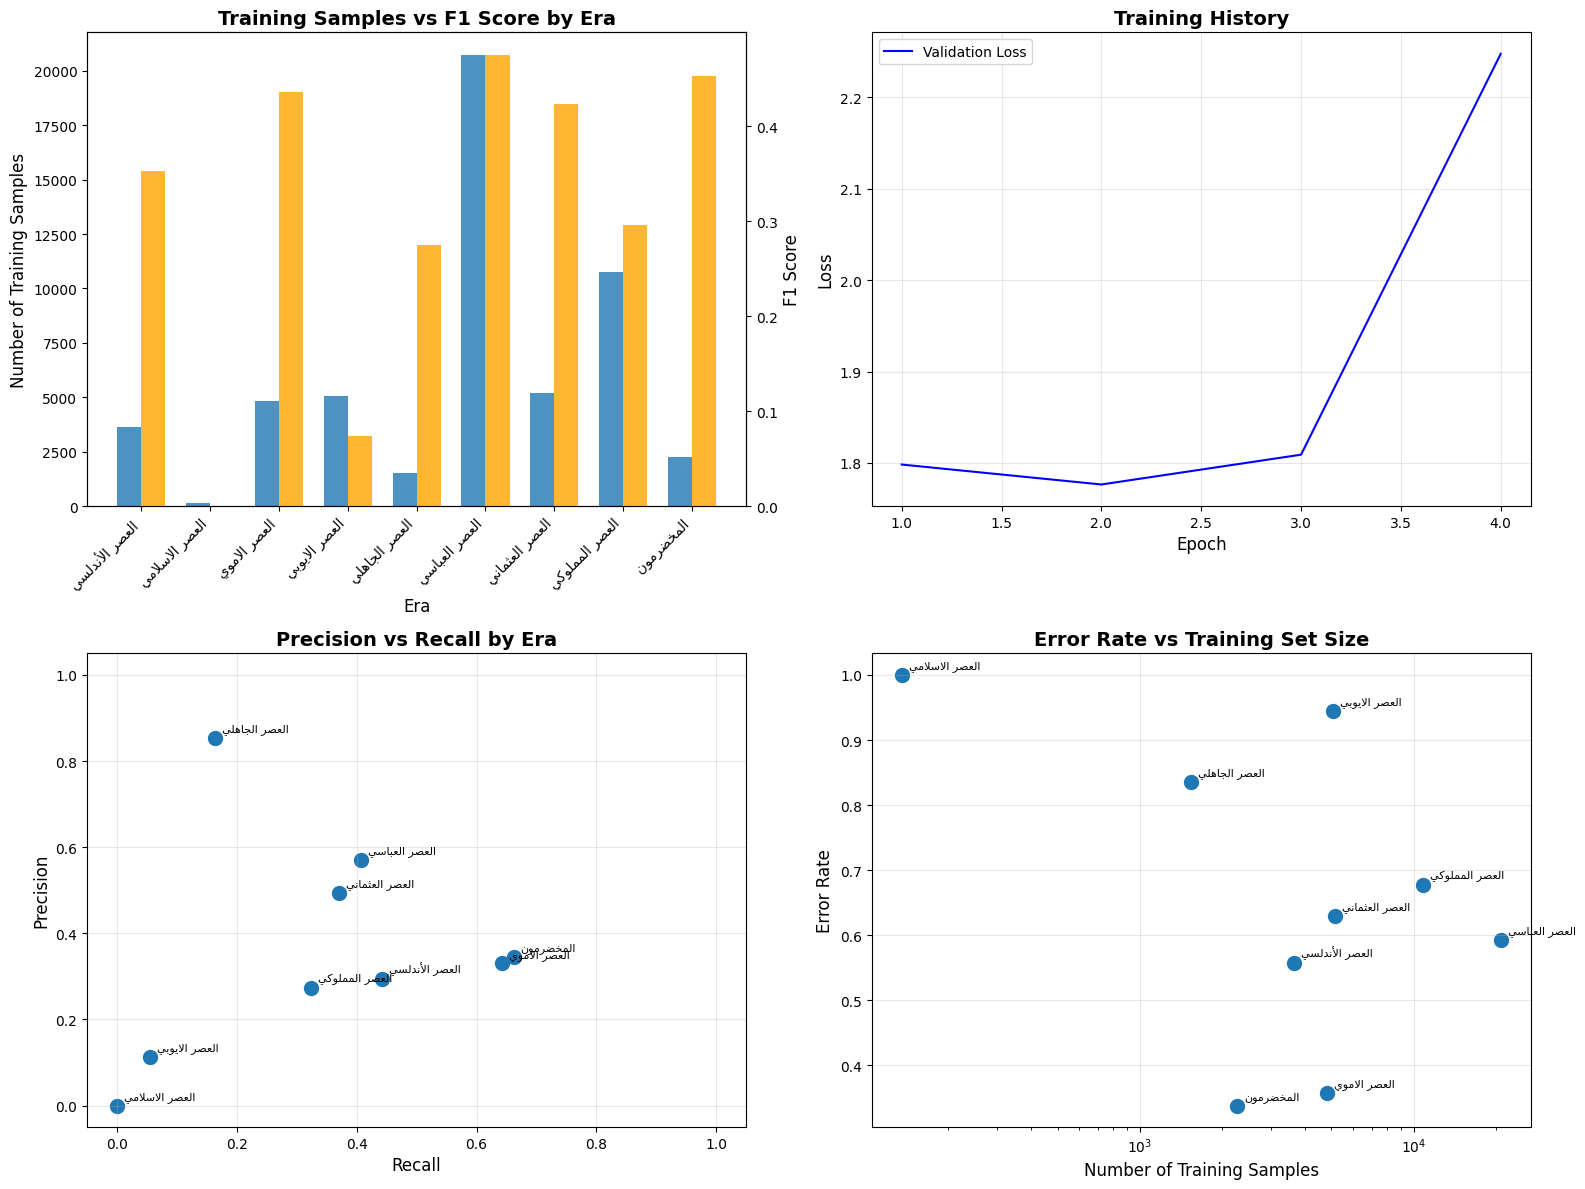

In [30]:
visualize_performance(train_class_dist, test_results, label_encoder)